## The following notebook includes functionality to initiate an instance of maxcut on the native CQ device topology for p=1, p=2, and varying numbers of qubits up to 25. We additionally have included logging functionality to begin to suss out where we need better simulators. We've included some limited functionality for finding the maxima across different instances to look for clustering.

In [1]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
from networkx import Graph, draw_planar
import numpy as np
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit
from qiskit import Aer, execute
from classical_optimization.qaoa_circuits import estimate_cost
from classical_optimization.qaoa_circuits import plot_landscape
%load_ext autoreload
%autoreload 2
%pdb

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Automatic pdb calling has been turned ON


In [2]:
from qiskit.visualization import plot_histogram


def the_whole_schebang(rows, cols, noise_model=None):
    neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
    neutral_atom_config = neutral_atom.configuration()
    coupling_map = neutral_atom_config.coupling_map
    g = Graph(coupling_map)
    #draw_planar(g)
    #np.random.seed(137)
    weights = set()
    for k in coupling_map:
        weights.add((min(k), max(k)))
    # Fix the weights to 1, for now.
    weights = {k: 1  for k in weights}

    def produce_gammas_betas(discretization, max_gamma, max_beta):
        return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

    discretization = 20
    max_gamma = max_beta = np.pi
    gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

    simulator = Aer.get_backend('qasm_simulator')
    num_shots = 1024
    experiments = []
    for gamma in gammas:
        for beta in betas:
            experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
    job = execute(experiments, backend=simulator, shots=num_shots, noise_model=noise_model)    
    all_counts = job.result().get_counts()    
    landscape = np.zeros((discretization, discretization))
    for i, gamma in enumerate(gammas):
        for j, beta in enumerate(betas):
            landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)
    return landscape, max_gamma, max_beta, betas, gammas, all_counts

In [3]:
optimal_pairs = []

In [4]:
import scipy.ndimage.filters as filters
neighborhood_size = 10
threshold = 0

def find_maxima(landscape):
    data = landscape
    data_max = filters.maximum_filter(data, (neighborhood_size, neighborhood_size))
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, (neighborhood_size, neighborhood_size))
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    maxima[0,:] = 0
    maxima[-1,:] = 0
    maxima[:,0] = 0
    maxima[:,-1] = 0
    # A[x,y] != A[x][y]
    # This is removing local maxima on the boundary (which at least don't exist on these regular graphs.)
    return np.where(maxima)

In [5]:
import pickle
with open('runtimes.pkl','rb') as handle:
    existing = pickle.load(handle)

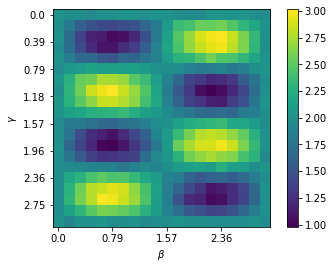

In [6]:
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline
optimal_pairs = {}
histograms = []
for rows,cols in [(2,2)]:#[(2,1), (2,2), (3,2), (3,3), (4,3), (4,4), (5,4), (5,5)]:
    start = time.time()
    landscape, max_gamma, max_beta, betas, gammas, all_counts = the_whole_schebang(rows, cols)
    stop = time.time()
    plot_landscape(landscape, max_gamma, max_beta)
    maxima = find_maxima(landscape)
    #plt.scatter(maxima[1], maxima[0], c='r',s=100)
    plt.show()
    pairs = list(zip(betas[maxima[0]], gammas[maxima[1]]))
    optimal_pairs[(rows,cols, len(betas)*len(gammas))] = (pairs, stop-start)
    histograms.append(plot_histogram(all_counts[np.argmax(landscape)]))

with open('runtimes.pkl','rb') as handle:
    existing = pickle.load(handle)
with open('runtimes.pkl','wb') as handle:
    new = {}
    new.update(existing)
    for k,v in optimal_pairs.items():
        pairs, times = existing.get(k, [[],[]])
        pairs.append(v[0])
        times.append(v[1])
        new[k] = [pairs, times]
    pickle.dump(new, handle)

# Now introduce noise!

In [7]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
noise_model = create_noise_model(cz_fidelity=0.7)

In [8]:
experiments = []
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map
g = Graph(coupling_map)
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
weights = set()
for k in coupling_map:
    weights.add((min(k), max(k)))
# Fix the weights to 1, for now.
weights = {k: 1  for k in weights}
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  

all_counts = job.result().get_counts()

In [9]:
def produce_gammas_betas(discretization, max_gamma, max_beta):
    return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

discretization = 20
noisy_landscape = np.zeros((discretization, discretization))
max_gamma = max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

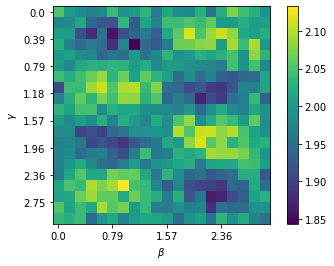

In [10]:
plot_landscape(noisy_landscape, max_gamma, max_beta);

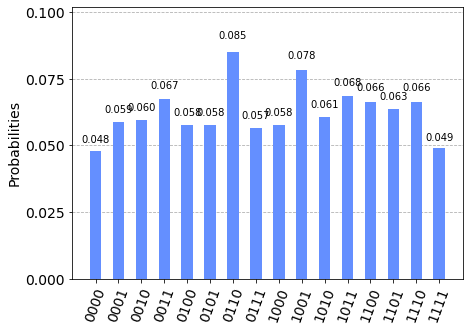

In [11]:
plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [12]:
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

$\gamma$,$\beta$=[3.51281354 2.5381658 ]
Max cut is 2.946


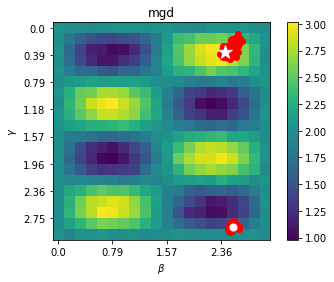

In [13]:
from classical_optimization.qaoa_circuits import try_optimizer
import matplotlib.pyplot as plt
noise_model = create_noise_model(cz_fidelity=0.7)
noise_model = None

for method in ['mgd']:#['nelder-mead', 'powell', 'mgd']:
    history = []
    result = try_optimizer(method, simulator, neutral_atom_config.coupling_map, shots_per_point,
                           weights, max_gamma, max_beta, rows, cols, history, noise_model)
    history.append(result.x) #We will append the last visited point, since the plotting assumes this is the optimal value.
    plot_landscape(landscape, max_gamma, max_beta, history=history, discretization=discretization)
    plt.title(method)
    plt.show()

## Larger Depths!

In [14]:
discretization = 8
max_gamma = max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

In [15]:
import tqdm as tqdm
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [16]:
landscape = np.zeros((discretization, discretization, discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        for k, gamma in enumerate(gammas):
            for l, beta in enumerate(betas):
                landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

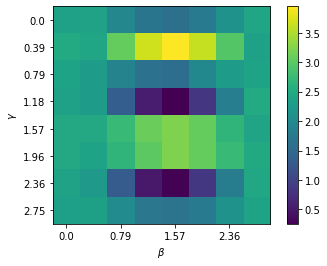

In [17]:
plot_landscape(landscape[np.unravel_index(landscape.argmax(), landscape.shape)[0:2]], max_gamma, max_beta, colorbar=True)

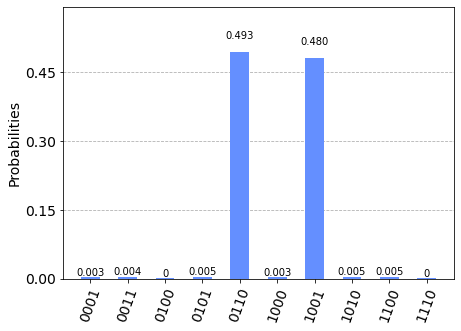

In [18]:
plot_histogram(all_counts[landscape.argmax()])

# With noise!

In [19]:
import tqdm as tqdm
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
noise_model = create_noise_model(cz_fidelity=.9)

simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
rows = cols = 2
weights = set()
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map
for k in coupling_map:
    weights.add((min(k), max(k)))
# Fix the weights to 1, for now.
weights = {k: 1  for k in weights}


for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots, noise_model=noise_model)    
all_counts = job.result().get_counts()

In [20]:
def produce_gammas_betas(discretization, max_gamma, max_beta):
    return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)
discretization = 10
max_gamma = 2*np.pi
max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)
noisy_landscape = np.zeros((discretization, discretization, discretization, discretization))
coupling_map = neutral_atom_config.coupling_map
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        for k, gamma in enumerate(gammas):
            for l, beta in enumerate(betas):
                noisy_landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

IndexError: list index out of range

> <ipython-input-20-a085d5db8a60>(13)<module>()
      9 for i, gamma in enumerate(gammas):
     10     for j, beta in enumerate(betas):
     11         for k, gamma in enumerate(gammas):
     12             for l, beta in enumerate(betas):
---> 13                 noisy_landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

ipdb> c


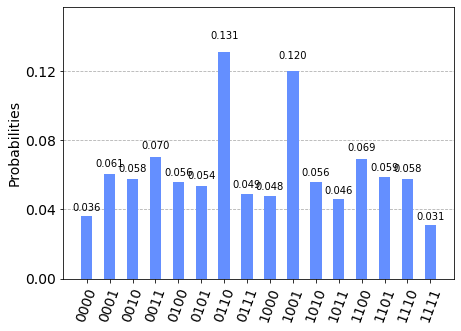

In [21]:
from qiskit.visualization import plot_histogram
plot_histogram(all_counts[np.argmax(noisy_landscape)])

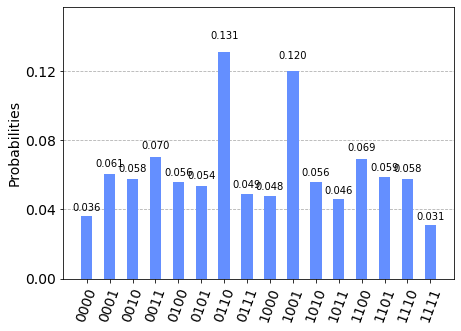

In [22]:
plot_histogram(all_counts[noisy_landscape.argmax()])

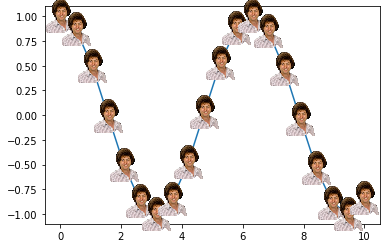

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

x = np.linspace(0, 10, 20)
y = np.cos(x)
image_path = get_sample_data('/Users/anthonypolloreno/Desktop/Untitled-1.png')
fig, ax = plt.subplots()
imscatter(x, y, image_path, zoom=0.1, ax=ax)
ax.plot(x, y)
plt.show()



# The most important take away from last meeting is the machine has an incredibly slow reprate - 50Hz. Thus our goal is simple - find optimization techniques that involve a small number of samples. We also need to develop a testing suite. The canidates for this are the RL algorithm and KDE from Yuri, APOSSUM if we're worried about not finding global maxima, and SA, SPSA, and Evolution Strategies. We'll start with SA.

In [3]:
from classical_optimization.qaoa_circuits import plot_history_over_landscape
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
from qiskit.quantum_info import DensityMatrix
 
noise_model = create_noise_model(cz_fidelity=0.9)

simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots, noise_model=noise_model)    
all_counts = job.result().get_counts()    
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

KeyboardInterrupt: 

In [74]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost

shots_per_point = 100

history = []
def store_log(func):
    def logged_func(x):
        history.append(x)
        return func(x)
    return logged_func

@store_log
def gamma_beta_objective(gamma_beta):
    return -execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[0], beta=gamma_beta[1],
                                                   num_shots=shots_per_point,
                                                   simulator=simulator,
                                                   coupling_map=coupling_map,
                                                   weights=weights,
                                                   rows=rows,
                                                   cols=cols,
                                                   noise_model=noise_model)

reprate = 50
one_hour = 60 * 60

initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(gamma_beta_objective,
                        bounds=[(0, 2*np.pi),
                                (0,np.pi)],
                        x0=np.array(initial_gamma_beta),
                        maxiter=1,
                        initial_temp=10,
                       maxfun=one_hour*reprate)

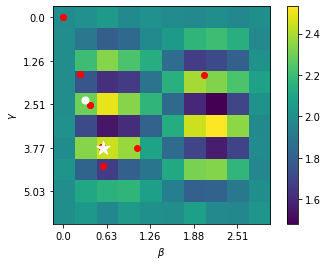

In [77]:
plot_history_over_landscape(history, landscape, discretization, max_gamma, max_beta)
#plt.scatter(max(history))

# We should consider time to solution, truncating after some time. I should look at the nature paper on the number of qubits needed for advantage.

In [2]:
import numpy as np
import networkx as nx


er_prob = .7
np.random.seed(137)
num_graphs = 10
num_nodes = 9

graphs = []
for _ in range(num_graphs):
    graphs.append(nx.erdos_renyi_graph(num_nodes, p=er_prob))